# RTC dataset comparison

Now that we have constructed and organized data cubes for both the ASF and Planetary Computer datasets, it would be useful and informative to comapre the two. This notebook will demonstrate steps to ensure a direct comparison between the two datasets as well as use of xarray plotting tools for visual comparison.

**Learning goals**
- add in

In [24]:
import xarray as xr

import s1_tools

from s1_tools import points2coords

import os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask
import holoviews as hv
from holoviews import opts


## Overview

While the datasets we will be comparing in this notebook are quite similar, they contain important differences related to how they were processed. The product description pages for both datasets contain important information for understanding how they are generated.

### Source data
One important difference is the source data used to generate the RTC images. ASF uses the Single Look Complex ([SLC](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/single-look-complex)) images that contains both amplitude and phase information for each pixel, is in radar coordinates and has not yet been multi-looked (double check). The Microsoft Planetary Computer RTC imagery is generate from ground range detected images (GRD). [GRD](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-1-sar/products-algorithms/level-1-algorithms/ground-range-detected) data has been detected, multi-looked and projected to ground range (**not the same as geocoded**). 

### DEM
A digital elevation model (DEM) is an important input parameter for RTC processing. ASF RTC processing uses the Copernicus DEM with 30 m resolution. Planetary Computer uses Planet DEMs (double check). One effect of the use of different DEMs during RTC processing is the different spatial resolutions of the RTC products: **Planetary Computer RTC imagery has a spatial resoution of 10 meters while ASF RTC imagery has a spatial resolution of 30 meters.**

anything else to add here?

## Functions

Here we will define all of the functions that will be used later in the notebook

**add doc strings to these, generalize**

In [25]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

In [26]:
def asf_pc_sidebyside(timestep):
    fig, axs = plt.subplots(ncols=2, figsize=(15,10))

    power_to_db(asf_subset.vv.isel(acq_date=timestep)).plot(ax=axs[0], cmap=plt.cm.Greys_r, label = 'ASF');
    power_to_db(pc_subset.sel(band='vv').isel(time=timestep)).plot(ax=axs[1], cmap=plt.cm.Greys_r, label = 'PC')

In [27]:
def single_time_mean_compare(time):
    fig, ax = plt.subplots(figsize=(8,8))
    power_to_db(asf_subset['vv_'].isel(acq_date=time).mean(dim=['x','y'])).plot(ax=ax)
    power_to_db(pc_subset.sel(band='vv').isel(time=time).mean(dim=['x','y'])).plot(ax=ax, color='red')

## Read in ASF dataset

We can use the `storemagic` command `%store` to retrieve the variable we constructed and saved in a previous notebook, rather than having to create it again. Read more about this [here](https://levelup.gitconnected.com/how-to-store-variables-in-jupyter-notebook-fea8aa60a9b)

In [28]:
%store -r

Read in the ASF dataset, which we named `vrt_full` in the earlier notebook:

In [29]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, x: 290, y: 396,
                                       sensor: 103, beam_mode: 103,
                                       acquisition_time: 103,
                                       polarisation_type: 103, orbit_type: 103,
                                       terrain_correction_pixel_spacing: 103,
                                       output_format: 103, output_type: 103,
                                       masked: 103, filtered: 103, area: 103,
                                       product_id: 103)
Coordinates: (12/19)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
  * sensor                            (sensor) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
  * masked                            (masked) <U1 'u' 'u' 'u' ... 'u' 'u' 'u'
  * filtered                          (filtered) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
  * area                              (area) <U1 'e' 'e' 'e' 'e' ... 'e' 'e' 'e'
  * product_id                        (product_id) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acquisition_time) int64 0 12 12 ... 12 0
    orbital_dir                       (acquisition_time) <U4 'asc' ... 'asc'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) uint8 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

Before we go further, the nodata value for the ASF dataset is currently zero ( I think this is an artifact of using VRT to read in the data). Change all zero values to NaN:

In [30]:
vrt_full =  vrt_full.where(vrt_full.vv != 0., np.nan, drop=False)

Read in the Planetary Computer dataset, which we named `da_pc` in the previous notebook:

In [31]:
da_pc

,Array,Chunk
Bytes,1.54 GiB,6.79 MiB
Shape,"(100, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,3 Graph Layers,400 Chunks
Type,float64,numpy.ndarray


## Extract common data take ID from granule IDs

We want to ensure that we are performing a direct comparison of the ASF and PC datasets. To do this, we would like to use the acquisition ID that is stored in the source granule name (published by ESA). In the earlier notebooks we attached the entire granule IDs of the SLC images to the ASF dataset and the GRD images to the PC dataset. Now we will extract just the 6-digit acquisition ID from both granule IDs and use these for a scene-by-scene comparison.

In [70]:
data_take_asf = [str(vrt_full.isel(acq_date = t).granule_id.values)[56:62] for t in range(len(vrt_full.acq_date))]

In [71]:
data_take_pc = [str(da_pc.isel(time=t).granule_id.values)[56:] for t in range(len(da_pc.time))]

Assign `data_take_id` as a non-dimensional coordinate. Rather than use the `xr.assign_coords()` function, we are adding the object by specifying a tuple with the form ('coord_name', coord_data, attrs):

In [72]:
vrt_full.coords['data_take_id'] = ('acq_date', data_take_asf, {'ID of data take from SAR acquisition':'ID data take'})
da_pc.coords['data_take_id'] = ('time', data_take_pc)

In [73]:
vrt_full

<xarray.Dataset>
Dimensions:                           (acq_date: 103, y: 396, x: 290,
                                       sensor: 103, beam_mode: 103,
                                       acquisition_time: 103,
                                       polarisation_type: 103, orbit_type: 103,
                                       terrain_correction_pixel_spacing: 103,
                                       output_format: 103, output_type: 103,
                                       masked: 103, filtered: 103, area: 103,
                                       product_id: 103)
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 2021-05-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
  * sensor                            (sensor) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
  * filtered                          (filtered) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
  * area                              (area) <U1 'e' 'e' 'e' 'e' ... 'e' 'e' 'e'
  * product_id                        (product_id) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acquisition_time) int64 0 12 12 ... 12 0
    orbital_dir                       (acquisition_time) <U4 'asc' ... 'asc'
    data_take_id                      (acq_date) <U6 '047321' ... '052C00'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [74]:
da_pc

,Array,Chunk
Bytes,1.54 GiB,6.79 MiB
Shape,"(100, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,3 Graph Layers,400 Chunks
Type,float64,numpy.ndarray


### Subset to only common data takes

Now we have data take ID coordinates for both datasets. We want to find the common data take IDs between the two datasets. TO do this, I extract a list of the acquisition IDs (`data_take_id`) for both datasets and then find the intersection of the two lists (the list object `common_data_takes`)

In [75]:
pc_data_take_ls = list(da_pc.data_take_id.values)
asf_data_take_ls = list(vrt_full.data_take_id.values)

In [76]:
common_data_takes  = list(set(pc_data_take_ls) & set(asf_data_take_ls))
len(common_data_takes)

84

It looks like there are 84 RTC images that are generated from common acquisitions between the two datasets

We'd like to subset the ASF and the PC datasets to only the common acquisitions. The xarray `.isin()` method is very useful for this type of selection. 

In [77]:
subset_condition_asf = vrt_full.data_take_id.isin(common_data_takes)

subset_condition_pc = da_pc.data_take_id.isin(common_data_takes)

Next, we want to select the elements along the `acq_ate` (and `time`) dimensions where `data_take_id` satisfies the requirement of being in the `common_data_takes` list. I found this stack overflow answer useful for this step: [https://stackoverflow.com/questions/70777676/xarray-select-dataarray-according-to-an-non-dimension-coordinate](https://stackoverflow.com/questions/70777676/xarray-select-dataarray-according-to-an-non-dimension-coordinate).

In [97]:
asf_subset = vrt_full.sel(acq_date = vrt_full.data_take_id.isin(common_data_takes))

In [98]:
pc_subset = da_pc.sel(time = da_pc.data_take_id.isin(common_data_takes))

In [99]:
pc_subset

,Array,Chunk
Bytes,1.29 GiB,6.79 MiB
Shape,"(84, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,4 Graph Layers,336 Chunks
Type,float64,numpy.ndarray


In [100]:
asf_subset

<xarray.Dataset>
Dimensions:                           (acq_date: 90, y: 396, x: 290,
                                       sensor: 103, beam_mode: 103,
                                       acquisition_time: 103,
                                       polarisation_type: 103, orbit_type: 103,
                                       terrain_correction_pixel_spacing: 103,
                                       output_format: 103, output_type: 103,
                                       masked: 103, filtered: 103, area: 103,
                                       product_id: 103)
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 2021-06-02 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
  * sensor                            (sensor) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
  * filtered                          (filtered) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
  * area                              (area) <U1 'e' 'e' 'e' 'e' ... 'e' 'e' 'e'
  * product_id                        (product_id) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acquisition_time) int64 0 12 12 ... 12 0
    orbital_dir                       (acquisition_time) <U4 'asc' ... 'asc'
    data_take_id                      (acq_date) <U6 '0480FD' ... '052C00'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

Interesting - each dataset should have 84 elements along the time dimension but the ASF dataset has 90. Let's look into what's going on, it seems like there may be some duplicate time steps in the dataset. 

#### Handling duplicate time steps 

```{note} 
maybe take this section out??
```

First, find duplicate data take values within the ASF dataset:

In [101]:
asf_ids = list(asf_subset.data_take_id.values)

In [102]:
def duplicate(input_ls):
    return list(set([x for x in input_ls if input_ls.count(x) > 1]))

duplicate_ls = duplicate(asf_ids)
duplicate_ls

['048D87', '05154A', '0492D4', '052C00']

There are 4 data take IDs that are duplicated within the ASF dataset. Make a subset of the ASF dataset that is just the duplicate time steps. I did this using the `xarray.DataArray.isin()` method and the `xarray.DataArray.where()` method.

In [103]:
asf_duplicate_cond = asf_subset.data_take_id.isin(duplicate_ls)
asf_duplicate_cond

asf_duplicates = asf_subset.where(asf_duplicate_cond == True, drop=True)

In [104]:
asf_duplicates

<xarray.Dataset>
Dimensions:                           (acq_date: 10, y: 396, x: 290,
                                       sensor: 103, beam_mode: 103,
                                       acquisition_time: 103,
                                       polarisation_type: 103, orbit_type: 103,
                                       terrain_correction_pixel_spacing: 103,
                                       output_format: 103, output_type: 103,
                                       masked: 103, filtered: 103, area: 103,
                                       product_id: 103)
Coordinates: (12/20)
  * acq_date                          (acq_date) datetime64[ns] 2021-07-01 .....
    granule_id                        (acq_date) <U67 'S1A_IW_SLC__1SDV_20210...
  * x                                 (x) float64 6.194e+05 ... 6.281e+05
  * y                                 (y) float64 3.102e+06 ... 3.09e+06
    spatial_ref                       int64 0
  * sensor                            (sensor) <U3 'S1A' 'S1A' ... 'S1A' 'S1A'
    ...                                ...
  * filtered                          (filtered) <U1 'n' 'n' 'n' ... 'n' 'n' 'n'
  * area                              (area) <U1 'e' 'e' 'e' 'e' ... 'e' 'e' 'e'
  * product_id                        (product_id) <U4 '748F' '0D1E' ... 'BD36'
    acq_hour                          (acquisition_time) int64 0 12 12 ... 12 0
    orbital_dir                       (acquisition_time) <U4 'asc' ... 'asc'
    data_take_id                      (acq_date) <U6 '048D87' ... '052C00'
Data variables:
    vv                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh                                (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls                                (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

There are 10 time steps that exist with the duplicate datasets. Not sure why they are there, but we reasonably only want one data array to exist for each data take ID. Let's see what these Data Arrays (single time steps) look like:

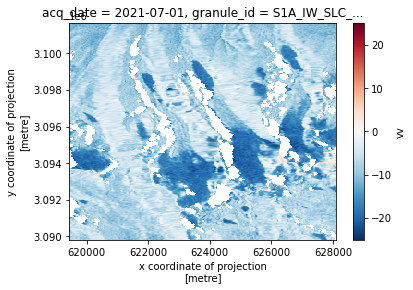

In [105]:
power_to_db(asf_duplicates.isel(acq_date=0).vv).plot()

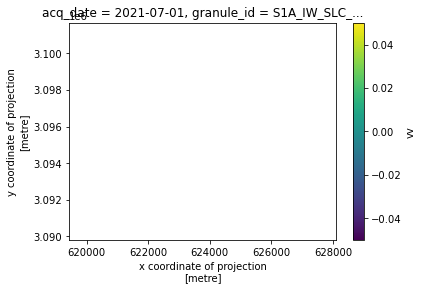

In [106]:
power_to_db(asf_duplicates.isel(acq_date=1).vv).plot()

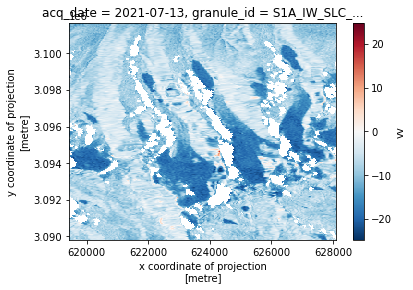

In [107]:
power_to_db(asf_duplicates.isel(acq_date=2).vv).plot()

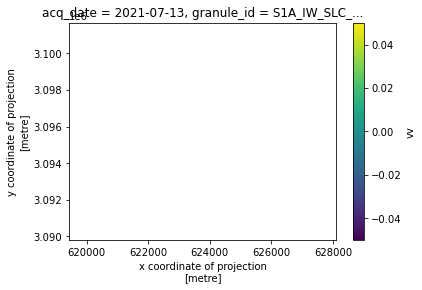

In [108]:
power_to_db(asf_duplicates.isel(acq_date=3).vv).plot()

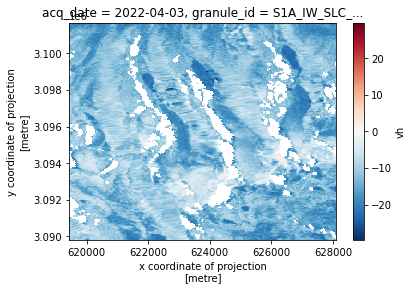

In [109]:
power_to_db(asf_duplicates.isel(acq_date=6).vh).plot()

It looks like many of these time steps do not contain any data (the data array is all zeros). Let's look at the coverage of non-zero pixels for each time step:

In [91]:
def single_time_mean_compare(asf_ds, pc_ds, time):
    fig, ax = plt.subplots(figsize=(8,8))
    power_to_db(asf_ds['vv'].isel(acq_date=time).mean(dim=['x','y'])).plot(ax=ax)
    power_to_db(pc_ds.sel(band='vv').isel(time=time).mean(dim=['x','y'])).plot(ax=ax, color='red')

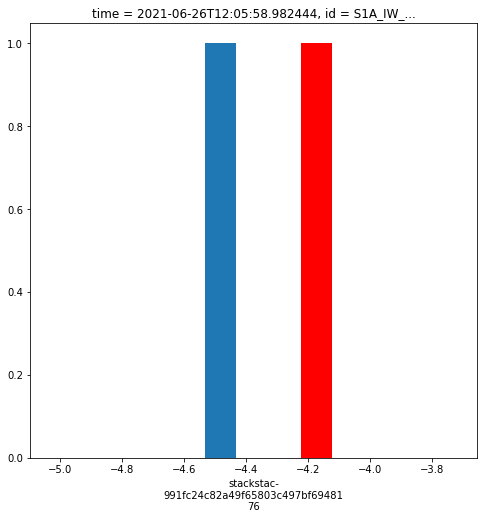

In [92]:
single_time_mean_compare(asf_subset, pc_subset, 6)

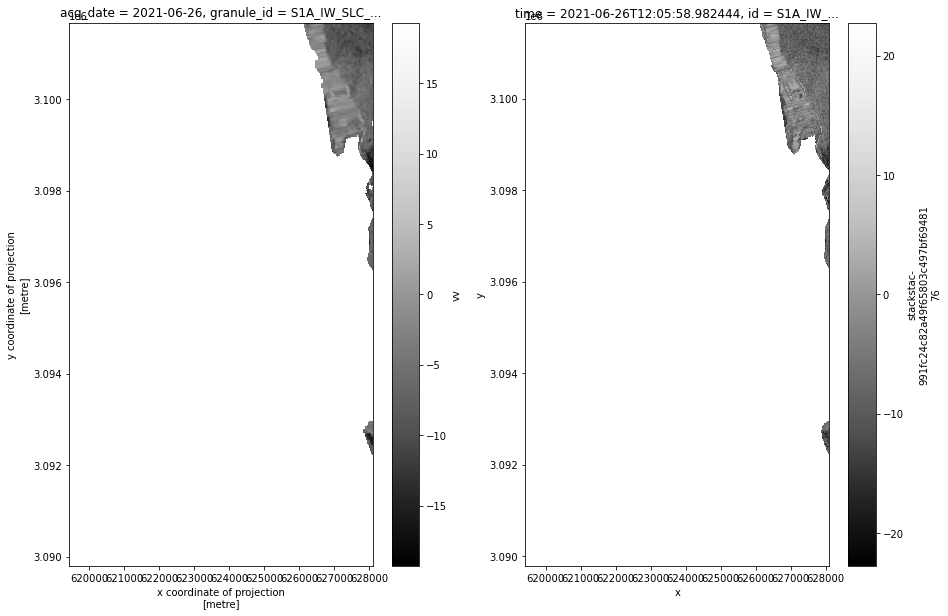

In [93]:
asf_pc_sidebyside(6)


### brute forcing drop times teps w low cov w a for loop:

```{note}
maybe take this out too
```

first, dropping unnecessary dimensions for simplicity's sake


In [110]:
asf_small = asf_subset.drop_dims(['sensor','beam_mode','polarisation_type','orbit_type','terrain_correction_pixel_spacing',
                                  'output_format','output_type','masked','filtered','area','product_id', 'acquisition_time'])

Turning zeros to nans

In [111]:
#turn zeros to nans
asf_small = asf_small.where(asf_small.vv != 0., np.nan, drop=False)

In [112]:
cov_ls, date_ls = [], []

for element in range(len(asf_small.acq_date)):
    
    total_pixels = asf_small.isel(acq_date=element).vv.shape[0] * asf_small.isel(acq_date=element).vv.shape[1]
    #print(total_pixels)
    num_nan = np.count_nonzero(np.isnan(asf_small.isel(acq_date=element).vv))
    cov = 1 - (num_nan/total_pixels)
    cov_ls.append(cov)
    
    date = asf_small.isel(acq_date = element).acq_date.values
    date_ls.append(date)
    #print('date ', date)
    
    cov_tuple = tuple(zip(date_ls, cov_ls))
    

In [113]:
asf_small.coords['cov'] = ('acq_date', cov_ls, {'coverage': 'calculated from # nan pixels / total pixels per time step'})

In [114]:
asf_small

<xarray.Dataset>
Dimensions:       (acq_date: 90, y: 396, x: 290)
Coordinates:
  * acq_date      (acq_date) datetime64[ns] 2021-06-02 2021-06-07 ... 2022-05-21
    granule_id    (acq_date) <U67 'S1A_IW_SLC__1SDV_20210602T120543_20210602T...
  * x             (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y             (y) float64 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref   int64 0
    data_take_id  (acq_date) <U6 '0480FD' '048318' ... '052C00' '052C00'
    cov           (acq_date) float64 0.04882 0.9077 0.9506 ... 0.0 0.0 0.908
Data variables:
    vv            (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh            (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls            (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

Now, remove tmie steps where `cov` does not exceet threshold:

In [115]:
asf_new = asf_small.where(asf_small.cov > 0.05, drop = True)

In [116]:
asf_new

<xarray.Dataset>
Dimensions:       (acq_date: 76, y: 396, x: 290)
Coordinates:
  * acq_date      (acq_date) datetime64[ns] 2021-06-07 2021-06-10 ... 2022-05-21
    granule_id    (acq_date) <U67 'S1A_IW_SLC__1SDV_20210607T121351_20210607T...
  * x             (x) float64 6.194e+05 6.195e+05 ... 6.281e+05 6.281e+05
  * y             (y) float64 3.102e+06 3.102e+06 ... 3.09e+06 3.09e+06
    spatial_ref   int64 0
    data_take_id  (acq_date) <U6 '048318' '04841E' ... '0526C4' '052C00'
    cov           (acq_date) float64 0.9077 0.9506 0.05404 ... 0.9077 0.908
Data variables:
    vv            (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    vh            (acq_date, y, x) float32 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>
    ls            (acq_date, y, x) float64 dask.array<chunksize=(1, 396, 290), meta=np.ndarray>

In [33]:
np.count_nonzero(np.isnan(pc_subset.sel(band='vv').isel(time=0)))

982152

## Visual comparison

still need to add in more structure, explanation here

#### Individual time steps

/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


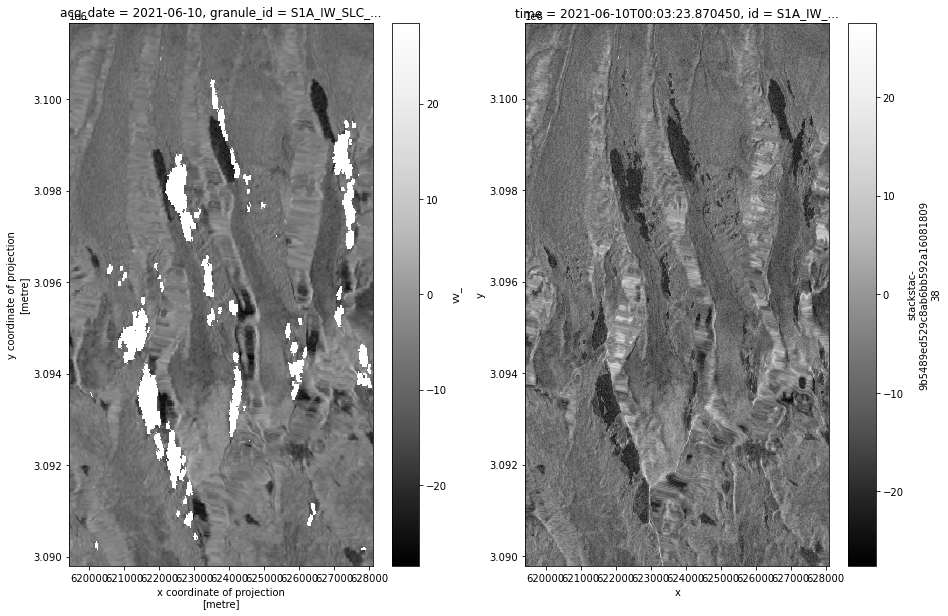

In [92]:
asf_pc_sidebyside(2)

/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


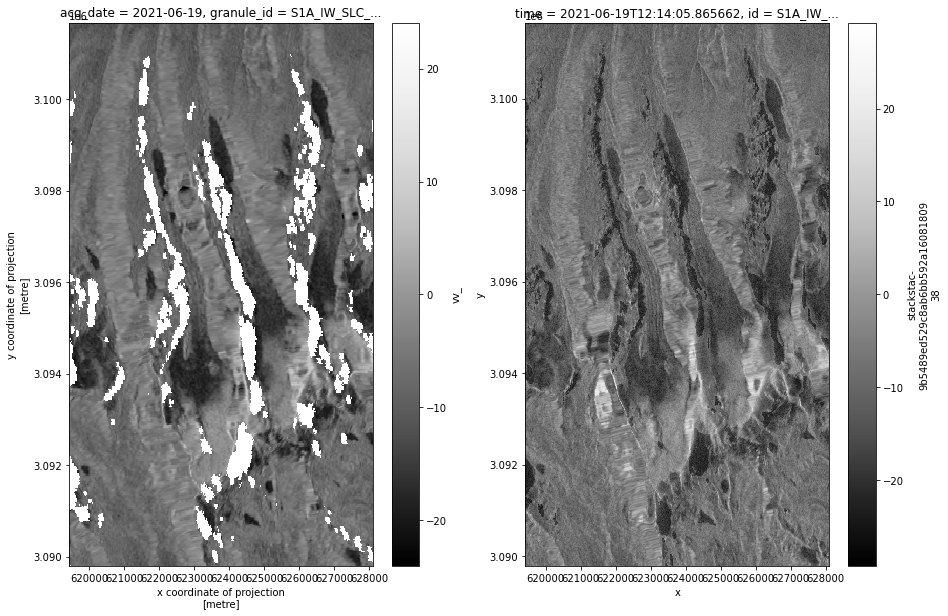

In [93]:
asf_pc_sidebyside(4)

/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


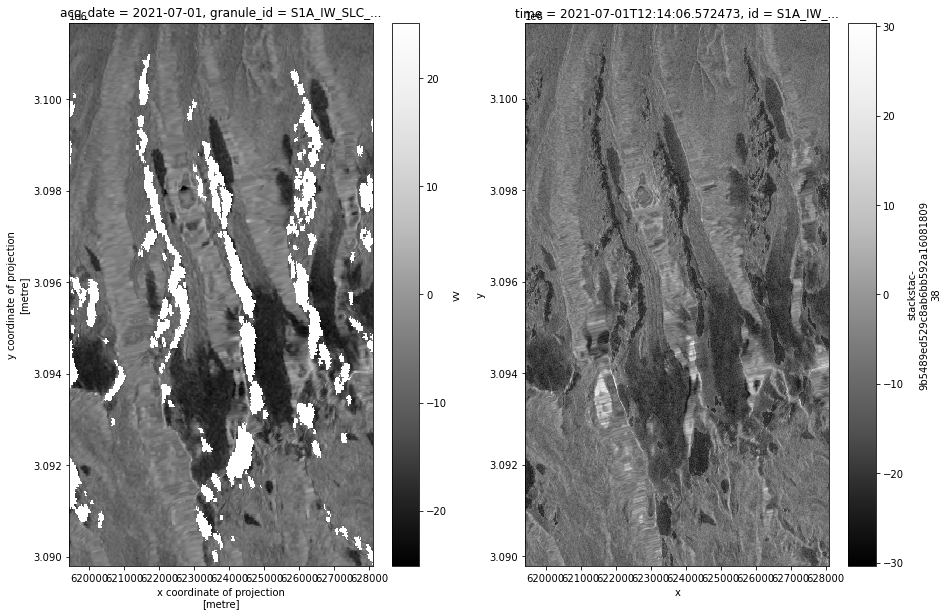

In [59]:
asf_pc_sidebyside(7)

/home/emmamarshall/miniconda3/envs/sentinel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


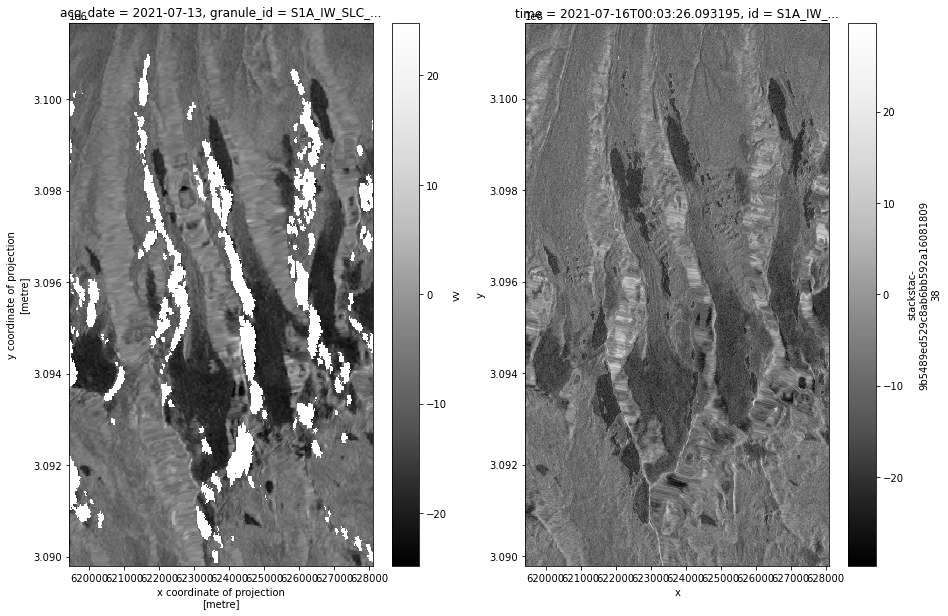

In [63]:
asf_pc_sidebyside(11)

#### Average backscatter over time

In [ ]:
fig, axs = plt.subplots(ncols = 2, figsize=(16,8))

power_to_db(asf_subset.vv.mean(dim=['x','y'])).plot(ax=axs[0], color='blue', linestyle='None', marker='o', markersize=5, label = 'ASF')
power_to_db(pc_subset.sel(band='vv').mean(dim=['x','y'])).plot(ax=axs[0], color='red', linestyle='None', marker='o', markersize=5, label='PC')

power_to_db(asf_small.vv.mean(dim=['x','y'])).plot(ax=axs[1], color='blue', linestyle='None', marker='o', markersize=5, label = 'ASF')
power_to_db(pc_subset.sel(band='vv').mean(dim=['x','y'])).plot(ax=axs[1], color='red', linestyle='None', marker='o', markersize=5, label='PC')

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))


xr.plot.hist(power_to_db(vrt_full.vv), ax=ax, color='blue')
xr.plot.hist(power_to_db(da_pc.sel(band='vv')), ax=ax, color='blue')